In [3]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [5]:
!$env:HTTP_PROXY=""
!$env:HTTPS_PROXY=""
!pip install faker

  ERROR: Could not find a version that satisfies the requirement faker (from versions: none)
ERROR: No matching distribution found for faker


In [4]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13660.33it/s]


In [5]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

In [6]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [7]:
print(human_vocab)

{' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}


In [8]:
print(machine_vocab)

{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}


In [9]:
print(X[:5])

[[12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
  36 36 36 36 36 36]
 [ 4  3  1  4  4  1  4 12 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
  36 36 36 36 36 36]
 [12  2  4  3  2 10  3 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
  36 36 36 36 36 36]
 [29 13 30 31 28 16 13 34  0 13 27 28 21 23  0  5 11  0  4 12 12  3 36 36
  36 36 36 36 36 36]
 [30 20 31 28 29 16 13 34  0 22 13 25 31 13 28 34  0  5  9  0  4 12 12  8
  36 36 36 36 36 36]]


In [10]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [10]:
%%html
## 2 - Neural machine translation with attention

* If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. 
* Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 
* The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


### 2.1 - Attention mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. 
* Here is a figure to remind you how the model works. 
    * The diagram on the left shows the attention model. 
    * The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
    * The attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>


In [12]:
%%html
Here are some properties of the model that you may notice: 

#### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.
- *Pre-attention* Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism.
    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps
- *Post-attention* LSTM: at the top of the diagram comes *after* the attention mechanism. 
    - The post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next. 

In [13]:
%%html
#### An LSTM has both a hidden state and cell state
* In the lecture videos, we were using only a basic RNN for the post-attention sequence model
    * This means that the state captured by the RNN was outputting only the hidden state $s^{\langle t\rangle}$. 
* In this assignment, we are using an LSTM instead of a basic RNN.
    * So the LSTM has both the hidden state $s^{\langle t\rangle}$ and the cell state $c^{\langle t\rangle}$. 

In [14]:
%%html
#### Each time step does not use predictions from the previous time step
* Unlike previous text generation examples earlier in the course, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.
* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

In [15]:
%%html
#### Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

In [16]:
%%html
#### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
- Recall in the lesson videos "Attention Model", at time 6:45 to 8:16, the definition of "e" as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
    - "e" is called the "energies" variable.
    - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
    - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
    - $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
    - $e^{\langle t, t' \rangle}$ is then used when computing the attention $a^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

In [18]:
%%latex
- The diagram on the right of figure 1 uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times.
- Then it uses `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
- The concatenation of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ is fed into a "Dense" layer, which computes $e^{\langle t, t' \rangle}$. 
- $e^{\langle t, t' \rangle}$ is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$.
- Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.
- We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

<IPython.core.display.Latex object>

In [19]:
%%html
### Implementation Details
   
Let's implement this neural translator. You will start by implementing two functions: `one_step_attention()` and `model()`.

#### one_step_attention
* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

##### Clarifying 'context' and 'c'
- In the lecture videos, the context was denoted $c^{\langle t \rangle}$
- In the assignment, we are calling the context $context^{\langle t \rangle}$.
    - This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{\langle t \rangle}$.

In [21]:
%%latex
#### Implement `one_step_attention`

**Exercise**: Implement `one_step_attention()`. 

* The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop.
* It is important that all $T_y$ copies have the same weights. 
    * It should not reinitialize the weights every time. 
    * In other words, all $T_y$ steps should have shared weights. 
* Here's how you can implement layers with shareable weights in Keras:
    1. Define the layer objects in a variable scope that is outside of the `one_step_attention` function.  For example, defining the objects as global variables would work.
        - Note that defining these variables inside the scope of the function `model` would technically work, since `model` will then call the `one_step_attention` function.  For the purposes of making grading and troubleshooting easier, we are defining these as global variables.  Note that the automatic grader will expect these to be global variables as well.
    2. Call these objects when propagating the input.
* We have defined the layers you need as global variables. 
    * Please run the following cells to create them. 
    * Please note that the automatic grader expects these global variables with the given variable names.  For grading purposes, please do not rename the global variables.
* Please check the Keras documentation to learn more about these layers.  The layers are functions.  Below are examples of how to call these functions.
    * [RepeatVector()](https://keras.io/layers/core/#repeatvector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://keras.io/layers/merge/#concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://keras.io/layers/merge/#dot)  
```Python
dot_product = dot_layer([var1,var2])
```

<IPython.core.display.Latex object>

In [11]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [12]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [13]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
# For the purposes of passing the automatic grader
# please do not modify this global variable.  This will be corrected once the automatic grader is also updated.
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense(len(machine_vocab), activation=softmax)

In [14]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(inputs=s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [15]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

In [17]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
### END CODE HERE ###

In [18]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [19]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 12s 1ms/step - loss: 17.1111 - dense_3_loss: 2.5612 - dense_3_accuracy: 0.4317 - dense_3_accuracy_1: 0.6649 - dense_3_accuracy_2: 0.3026 - dense_3_accuracy_3: 0.0696 - dense_3_accuracy_4: 0.9224 - dense_3_accuracy_5: 0.3311 - dense_3_accuracy_6: 0.0370 - dense_3_accuracy_7: 0.9535 - dense_3_accuracy_8: 0.2282 - dense_3_accuracy_9: 0.1083


In [20]:
model.load_weights('models/model.h5')

In [21]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output),"\n")

ValueError: Error when checking input: expected input_1 to have 3 dimensions, but got array with shape (37, 30)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

<Figure size 432x288 with 0 Axes>

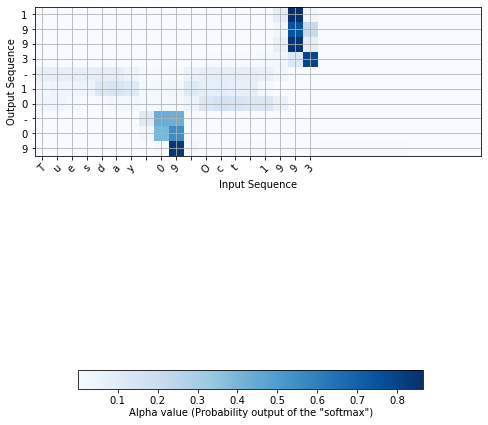

In [23]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);